# Reconstrucing astronomical spectra using Principle Component Analysis
Bayu Wilson

The purpose of this project is to review the process and power of Principle Component Analysis (PCA). This is not meant to be a rigorous calculation for quasar spectra reconstruction. This project uses some ideas from [this](https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html) resource.

In [610]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Loading XQ-100 quasar spectra

You'll have to download the data if you want to acutually run this. See the README.md for more details.

In [611]:
path_to_cat = "XQ100_data/XQ-100_catalogue.txt" #tells us names and redshift of each quasar.
catalog_table = pd.read_csv(path_to_cat,delim_whitespace=True,usecols=(3,6),
                                names = ("qso_name","redshifts"), comment='#')

df_tot = pd.DataFrame()
for i in range(len(catalog_table)):
    name = catalog_table["qso_name"].iloc[i]
    redshift = catalog_table["redshifts"].iloc[i]
    released_path = "XQ100_data/released/{0}_uvb-vis.txt".format(name)
    continuum_path = "XQ100_data/continuum/{0}_cont.txt".format(name)
    df_i = pd.read_csv(released_path, delim_whitespace=True, skiprows = 1,usecols=(0,1,2,3,4),
                                        names = ("wav", "flx", "ferr", "res","dloglam"))
    cont_table = pd.read_csv(continuum_path, delim_whitespace=True, skiprows = 1,usecols=(0,1),
            names = ("wav",'flx'))
    df_i["qso_idx"] = i
    df_i["redshift"] = redshift
    df_i["cont"] = cont_table["flx"]
    df_tot = pd.concat([df_tot,df_i])
df_tot["wav_rest"] = df_tot["wav"]/(1+df_tot["redshift"]) #shifting to rest frame

## Exploratory Data Analysis

### A typical XQ-100 quasar spectrum

Text(0.34, 0.47, 'hand-picked continuum')

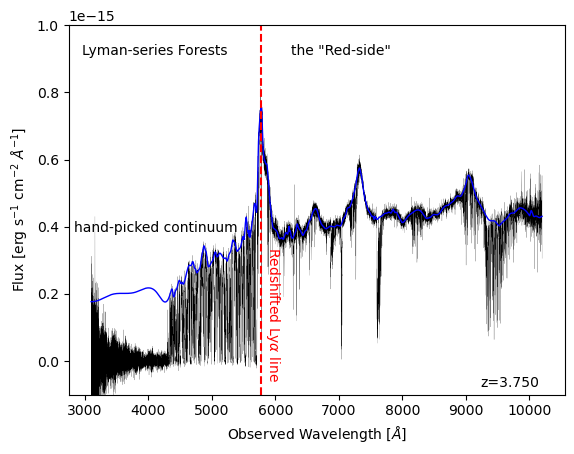

In [612]:
np.random.seed(1)
random_qso_idx = np.random.randint(0,100)
df_i = df_tot[df_tot["qso_idx"]==random_qso_idx]
z = df_i["redshift"][0]
plt.plot(df_i["wav"],df_i["flx"],lw=0.1,color='black')
plt.plot(df_i["wav"],df_i["cont"],lw=1,color='blue')
plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
plt.xlabel(r"Observed Wavelength [$\AA$]")
plt.ylim(-1e-16,1e-15)
plt.text(0.95, 0.05, f"z={z:.3f}", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.text(0.32, 0.95, f"Lyman-series Forests", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
plt.text(0.65, 0.95, f"the \"Red-side\"", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.axvline(1215.67*(1+z),color='red',ls="dashed")
plt.text(0.43, 0.4, r"Redshifted Ly$\alpha$ line", transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',rotation=-90,color='red')

plt.text(0.34, 0.47, "hand-picked continuum", transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
# plt.savefig("quasar_spectrum_example.png")

### The entire XQ-100 sample and the quasar redshift distribution

To give an idea of what all 100 of the quasars look like and what their redshift distribution is.

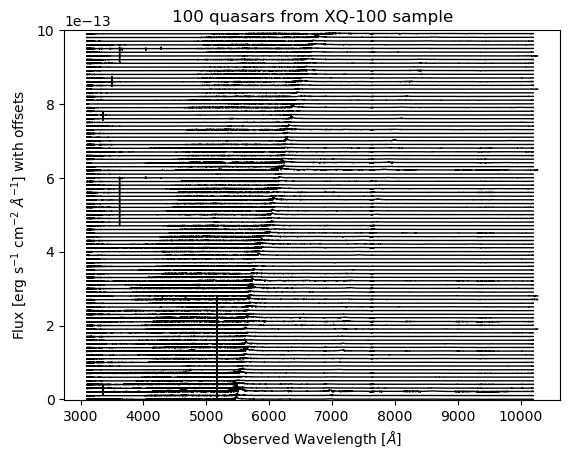

Text(0.5, 0, 'Redshift, z')

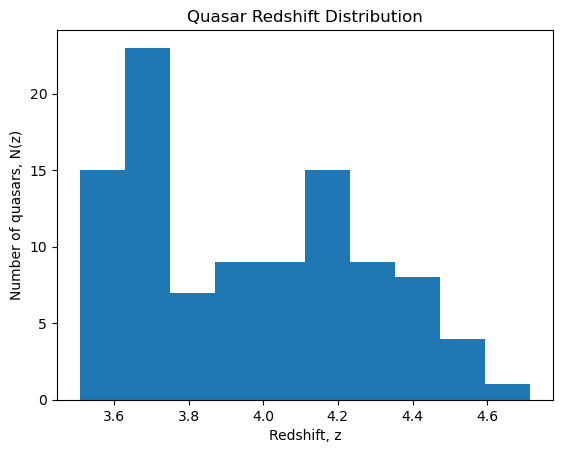

In [613]:
N_qso = 100 #len(qso_list)
flux_bias_plotting = 1e-14
for i in range(N_qso):
    df_i = df_tot[df_tot["qso_idx"] == i]
    wav_rest = df_i["wav"]
    flx = df_i["flx"]+flux_bias_plotting*i
    plt.plot(wav_rest, flx,lw=1,color='k')
plt.ylim(-1e-15,1e-14*N_qso)
plt.title("100 quasars from XQ-100 sample")
plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$] with offsets")
plt.xlabel(r"Observed Wavelength [$\AA$]")
plt.show()

# N(z) distribution
plt.title("Quasar Redshift Distribution")
plt.hist(np.unique(df_tot["redshift"]))
plt.ylabel("Number of quasars, N(z)")
plt.xlabel("Redshift, z")

### Shifting into wavelength rest-frame

We shift into the rest-frame so that features like the Ly$\alpha$ line match up between each spectrum. Unfortunately, it looks like the fluxes of each spectrum are a lot different. We're going to have to find a way to normalize the spectra. By the way, we're only going to be attempting to reconstruct the red-side of the spectrum which is shaded in gray. The red-side (rightward of the 1216 Anstrom lyman alpha line) is easier because there are less absorptions and so the continuum is easier to predict.

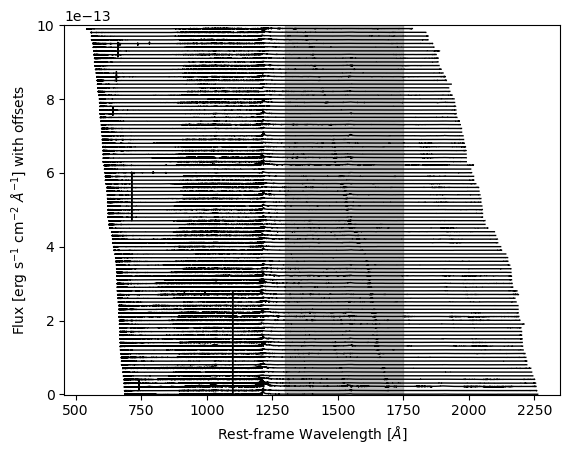

In [614]:
for i in range(100):
    df_i = df_tot[df_tot["qso_idx"] == i]
    wav_rest = df_i["wav_rest"]
    flx = df_i["flx"]
    plt.plot(wav_rest, flx+1e-14*i,lw=1,color='k')
plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$] with offsets")
plt.xlabel(r"Rest-frame Wavelength [$\AA$]")
plt.ylim(-1e-15,1e-14+1e-14*i)
plt.axvspan(1300,1750,color='gray',alpha=0.5)
plt.show()

### Normalizing the spectra and then calculating average and variance of the quasar spectra

We'll use the sci-kit learn preprocessing module to do this

In [615]:
from sklearn import preprocessing
from scipy.interpolate import griddata

In [616]:
N_qso = 100
all_fluxes = [] 
num_wave_bins = []
mask_subset = (df_tot["wav_rest"]>1020)&(df_tot["wav_rest"]<1750)
df_subset = df_tot[mask_subset]
wave_grid = df_subset[df_subset["qso_idx"] == 0]["wav_rest"].values
for i in range(N_qso):
    df_i = df_subset[df_subset["qso_idx"] == i]
    regridded_flux = griddata(df_i["wav_rest"].values,df_i["cont"].values,wave_grid,method='linear')
    all_fluxes.append(regridded_flux[1:-1])
wave_grid = wave_grid[1:-1]
X = np.stack(all_fluxes) #(number of samples (100 quasars),number of features (flux in wavelength bins))

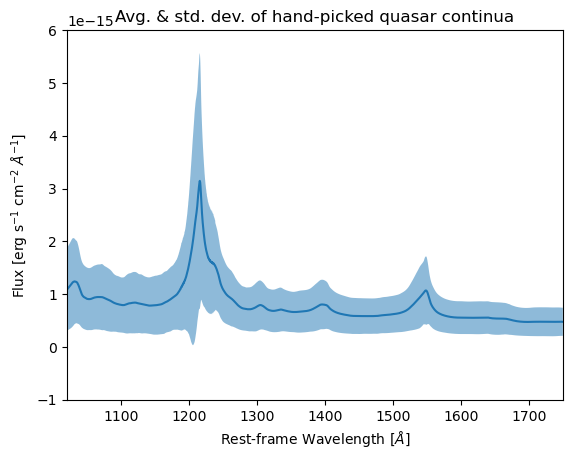

In [617]:
X_pp = preprocessing.normalize(X) #normed fluxes, num_quasars
mu = X.mean(0)
std = X.std(0)
plt.plot(wave_grid, mu)
plt.fill_between(wave_grid, mu - std, mu + std,alpha=0.5)
plt.xlim(1020,1750)
plt.ylim(-1e-15,6e-15)

plt.ylabel(r"Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
plt.xlabel(r"Rest-frame Wavelength [$\AA$]")
plt.title("Avg. & std. dev. of hand-picked quasar continua");


### Covariance and correlation matrices

This informs whether a correlation between the red and blue side exist at all!

In [676]:
cov_matrix = np.cov(X_pp,rowvar=False)
std_devs = np.sqrt(np.diag(cov_matrix))
correlation_matrix = cov_matrix / np.outer(std_devs, std_devs)

/var/folders/nl/x715pbd14cjb8kswwg48b99r0000gn/T/ipykernel_7794/864312562.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(newlabels)
/var/folders/nl/x715pbd14cjb8kswwg48b99r0000gn/T/ipykernel_7794/864312562.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newlabels)


Text(0.5, 0, 'Restframe wavelength $\\AA$')

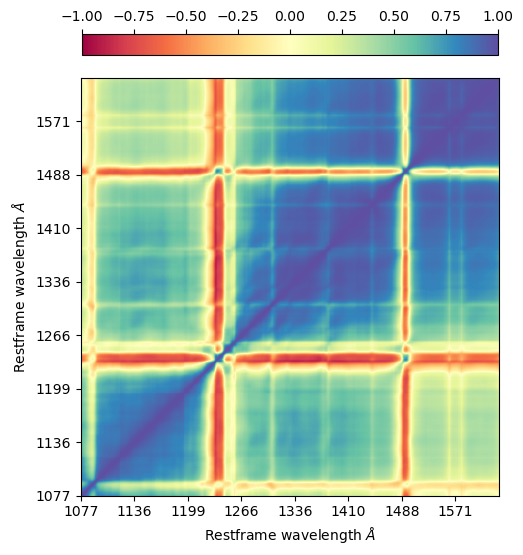

In [739]:
fig,ax = plt.subplots(1,figsize=(6,6))
im = ax.imshow(correlation_matrix,origin='lower',vmin=-1,vmax=1,cmap='Spectral')
fig.colorbar(im, ax=ax, orientation="horizontal",fraction=0.045, pad=0.05,location='top')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_ylabels()
# ax.set_yticks(wave_grid)
newlabels = [f"{i:.0f}" for i in  wave_grid[np.arange(0,len(wave_grid),int(len(wave_grid)/10))]][:-1]
ax.set_yticklabels(newlabels)
ax.set_xticklabels(newlabels)

ax.set_ylabel(r"Restframe wavelength $\AA$")
ax.set_xlabel(r"Restframe wavelength $\AA$")

In the above correlation matrix, it looks like there is a moderate correlation between the redside and the continuum of the Lyman-alpha forest.

### Getting matrixes for the full and red-side spectra

$X_\mathrm{pp}$: matrix with dimensions (number of quasars, number of wavelength pixels in full spectra) = (100, 7812)

$X_\mathrm{red}$ matrix with dimensions (number of quasars, number of wavelength pixels in full spectra) = (100, 5269)

In [618]:
index_redside = np.where(wave_grid>1216)[0][0]
wave_grid_redside = wave_grid[wave_grid>1216]
X_red = X_pp[:,index_redside:]

### Computing principle components for the full and red-side spectra

`pca_*.fit`: takes in training data $X$ of shape (n_samples, n_features) and then calculates PCA on the data. n_samples is the number of samples and n_features is the number of features. So in this case, n_samples = 100 quasars and n_features are the spectral wavelength bins. We choose 10 components.

We calculate PCA components for both the full and red-side separately. 

`pca_*.components_` gives the eigenvectors of shape (n_components, n_features) = (10, 5268 or 7812)

`spec_mean_*` gives the average spectrum over all of the data. Shape (n_features)


In [619]:
from sklearn.decomposition import PCA
pca_full = PCA(n_components=10)
pca_full.fit(X_pp) 

pca_redside = PCA(n_components=10)
pca_redside.fit(X_red);

evecs_full = pca_full.components_
spec_mean_full = X_pp.mean(0)

evecs_redside = pca_red.components_
spec_mean_redside = X_red.mean(0)

### Let's check if 10 principal components are enough

Text(0.05, 0.95, 'Red-side only')

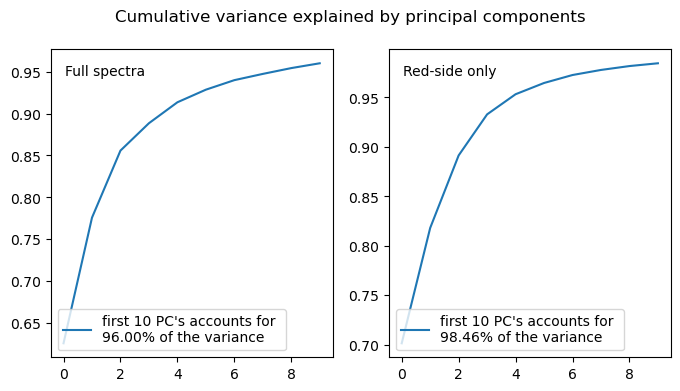

In [620]:
evals_full = pca_full.explained_variance_ratio_
evals_full_cs = evals_full.cumsum()
evals_red = pca_red.explained_variance_ratio_
evals_red_cs = evals_red.cumsum()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
n_components = 10 
x = np.arange(0,n_components,1)
label_full = f"first {n_components} PC's accounts for \n{evals_full_cs[-1]*100:.2f}% of the variance"
plt.suptitle("Cumulative variance explained by principal components")
ax[0].plot(x,evals_full_cs,label =label_full)
ax[0].legend(loc='lower left')
ax[0].text(0.05, 0.95, f"Full spectra", transform=ax[0].transAxes, verticalalignment='top', horizontalalignment='left')

label_red = f"first {n_components} PC's accounts for \n{evals_red_cs[-1]*100:.2f}% of the variance"
plt.suptitle("Cumulative variance explained by principal components")
ax[1].plot(x,evals_red_cs,label =label_red)
ax[1].legend(loc='lower left')
ax[1].text(0.05, 0.95, f"Red-side only", transform=ax[1].transAxes, verticalalignment='top', horizontalalignment='left')

### Reconstrucing continuum spectra

Using only the full PCS, we can reconstruct the continuum with the following:

$$ q^\mathrm{full}(\lambda) = \mu(\lambda) + \sum_{j=1}^{m} c_j \xi_j(\lambda) $$
where $\xi_j(\lambda)$ are the eigenvectors for the $j$th PC $c_j$ are the eigenvalue/weight of the eigenvector for each PC, and $\mu(\lambda)$ is the average continuum. The eigenvalues can be found using:

$$ C = \xi_j(\lambda) \cdot (q_i(\lambda)-\mu(\lambda))^T$$
where $\xi_j(\lambda)$ has shape (10,wavelength bins) and \mu(\lambda) has shape (100, 5268) such that the weight matrix, $C$, has shape (10,100). This can be interpreted as the weights for each of the 10 eigenvectors for each of the 100 quasars.

This same process can be done to reconstruct the continuum of the **red-side**:

$$ q^\mathrm{red}(\lambda) = \mu(\lambda) + \sum_{j=1}^{m} d_j \zeta_j(\lambda) $$
where $\zeta_j(\lambda)$ are the eigenvectors for the $j$th PC $c_j$ are the eigenvalue/weight of the eigenvector for each PC, and $\mu(\lambda)$ is the average continuum. The eigenvalues can be found using:

$$ D = \zeta_j(\lambda) \cdot (q_i(\lambda)-\mu(\lambda))^T$$
where $\zeta_j(\lambda)$ has shape (10, 7812) and \mu(\lambda) has shape (100, wavelength bins) such that the weight matrix, $D$, has shape (10,100). 


The idea is that we use the red-side weights ($D$) to predict the full spectra weights ($C$). We can find a projection matrix. This can be done by finding a projection matrix $P$ that translates the weights.
$$ C = D\cdot P $$ 
We can solve for the projection matrix if matrix $D$ is pseudo-invertible (it's not square).
$$ P = D^{-1}\cdot C $$ 

In the following, we will define the predicted full weights to be:

$$ \hat C = D\cdot P$$

So then the predicted, reconstructed spectrum will be
$$ \hat q^\mathrm{full}(\lambda) = \mu(\lambda) + \sum_{j=1}^{m} \hat c_j \xi_j(\lambda) $$

Note that $\sum_{j=1}^{m} \hat c_j \xi_j(\lambda)$ is equal to $\hat C^T \cdot \xi_j(\lambda)$ where $\hat C$ and $\xi_j(\lambda)$ have dimensions (10,100) and (10,7812) respectively.

In [621]:
weights_full = np.dot(evecs_full,(X_pp-spec_mean_full).T) #matrix C
weights_redside = np.dot(evecs_redside,(X_red-spec_mean_redside).T) # matrix D

proj_calc = np.dot(weights_redside,np.linalg.pinv(weights_full)) #matrix P calculated in this work. shape (10,10)
pred_weights = np.dot(proj_calc,weights_redside)

proj_precalc = np.loadtxt("proj.dat") #matrix P calculated in Paris et al. 2011 #it doesn't give a good result so I don't show it below.

Text(0.5, 0.98, 'weights for each PC and each quasar')

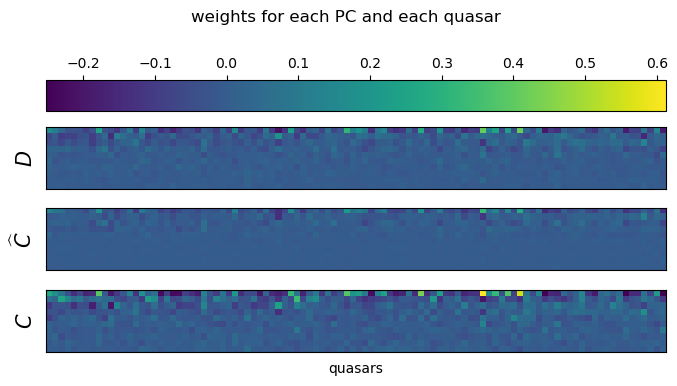

In [622]:
# to give an idea of what these weight matrixes look like
vmin = min(weights_redside.min(), pred_weights.min(), weights_full.min())
vmax = max(weights_redside.max(), pred_weights.max(), weights_full.max())
fig,ax = plt.subplots(3,figsize=(8,4))
im0 = ax[0].imshow(weights_redside, vmin=vmin, vmax=vmax,)
im1 = ax[1].imshow(pred_weights, vmin=vmin, vmax=vmax)
im2 = ax[2].imshow(weights_full, vmin=vmin, vmax=vmax)
fig.colorbar(im0, ax=ax, orientation="horizontal",fraction=0.2, pad=0.05,location='top')
ax[0].set_ylabel(r"$D$",fontsize=15)
ax[1].set_ylabel(r"$\widehat C$",fontsize=15)
ax[2].set_ylabel(r"$C$",fontsize=15)
ax[2].set_xlabel("quasars")
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.suptitle('weights for each PC and each quasar')
# ax[2].colorbar(orientation="horizontal")
# plt.show()

There may be something wrong with the way I calculated the projection matrix, but at least this is the idea.

### First let's just see how well spectral reconstruction works without trying to predict the blue/full spectrum

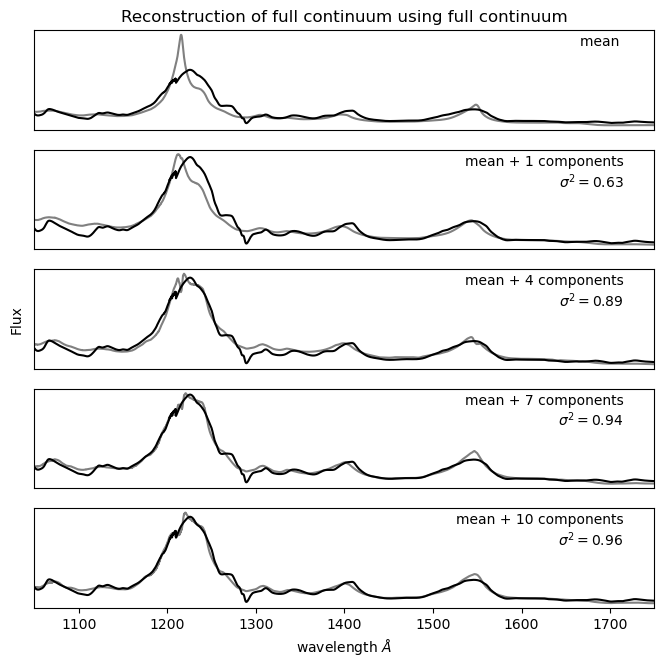

In [623]:
qso_idx = 14
N_comps_list =[0,1,4,7,10] 
spec = X_pp[qso_idx]

nrows = len(N_comps_list)
fig,ax = plt.subplots(nrows=nrows,figsize = (8,1.5*nrows))
ax[0].text(0.95, 0.95, f"mean ", transform=ax[0].transAxes, verticalalignment='top', horizontalalignment='right')
for i in range(nrows):
    N = N_comps_list[i]
    spectral_flucs_full =  np.dot(weights_full[:N].T,evecs_full[:N])[qso_idx]
    
    ax[i].plot(wave_grid,spec_mean_full+spectral_flucs_full,color='gray')
    ax[i].plot(wave_grid,spec,color='k')
    
    ax[i].set_xlim(1050,1750)
    ax[i].set_yticks([])
    if i!=nrows-1:
        ax[i].set_xticks([])
    if i!=0:
        ax[i].text(0.95, 0.95, f"mean + {N} components\n$\sigma^2=${evals_full_cs[N-1]:.2}", 
                   transform=ax[i].transAxes, verticalalignment='top', horizontalalignment='right')
ax[2].set_ylabel("Flux")
ax[nrows-1].set_xlabel(r"wavelength $\AA$")
ax[0].set_title("Reconstruction of full continuum using full continuum");

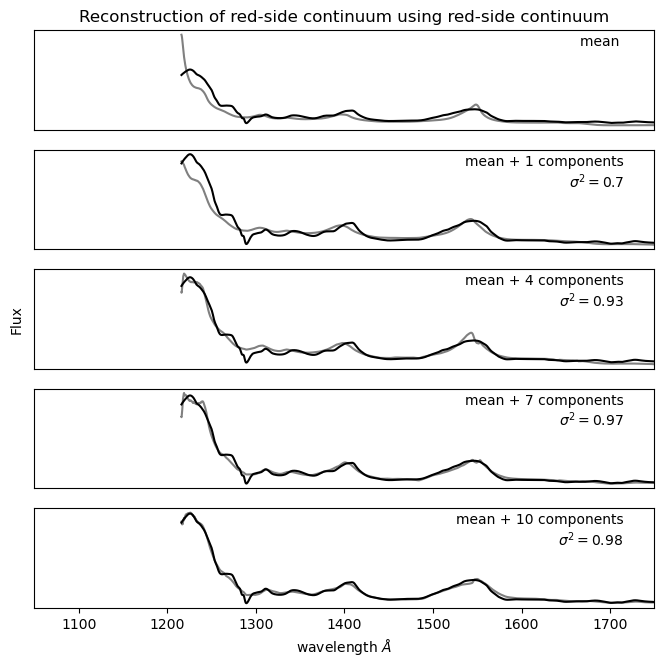

In [624]:
qso_idx = 14
N_comps_list =[0,1,4,7,10] 
spec = X_red[qso_idx]

nrows = len(N_comps_list)
fig,ax = plt.subplots(nrows=nrows,figsize = (8,1.5*nrows))
ax[0].text(0.95, 0.95, f"mean ", transform=ax[0].transAxes, verticalalignment='top', horizontalalignment='right')
for i in range(nrows):
    N = N_comps_list[i]
    spectral_flucs_redside =  np.dot(weights_redside[:N].T,evecs_redside[:N])[qso_idx]
    
    ax[i].plot(wave_grid_redside,spec_mean_redside+spectral_flucs_redside,color='gray')
    ax[i].plot(wave_grid_redside,spec,color='k')
    
    ax[i].set_xlim(1050,1750)
    ax[i].set_yticks([])
    if i!=nrows-1:
        ax[i].set_xticks([])
    if i!=0:
        ax[i].text(0.95, 0.95, f"mean + {N} components\n$\sigma^2=${evals_red_cs[N-1]:.2}", 
                   transform=ax[i].transAxes, verticalalignment='top', horizontalalignment='right')
ax[2].set_ylabel("Flux")
ax[nrows-1].set_xlabel(r"wavelength $\AA$")
ax[0].set_title("Reconstruction of red-side continuum using red-side continuum");

### How this would work in practice

1) You take quasar spectra data and find that the red-side is relatively un-absorbed. This means the continuum is easy to predict. But then, strong Lyman series absorption makes it very difficult to predict the blue side continuum. 
2) Do PCA on the red-side quasar spectra to find the red-side weights, $D$, for each of the PC and quasar samples.
3) Use either a pre-computed projection matrix (or calculate it yourself) in order to project the red-side weightst to the full-spectrum weights.
4) Use these predicted weights to reconstruct the full quasar continuum.


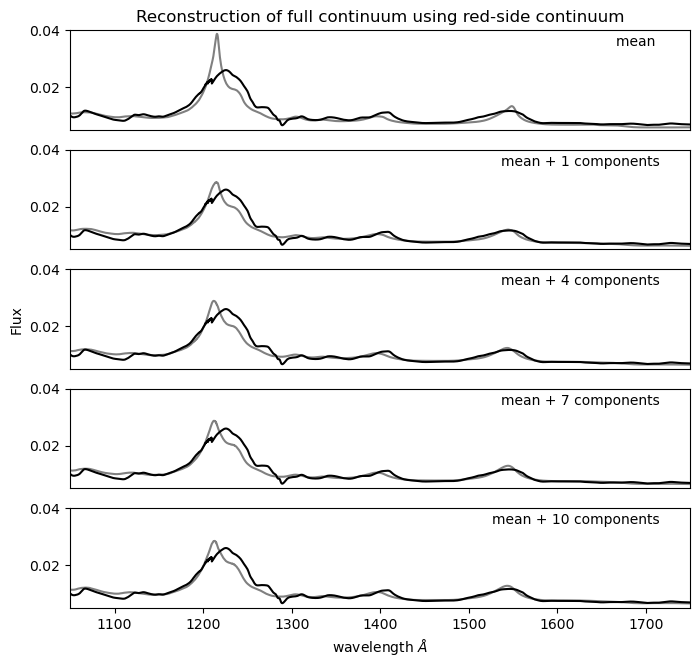

In [630]:
qso_idx = 14
N_comps_list =[0,1,4,7,10] 
spec = X_pp[qso_idx]

nrows = len(N_comps_list)
fig,ax = plt.subplots(nrows=nrows,figsize = (8,1.5*nrows))
ax[0].text(0.95, 0.95, f"mean ", transform=ax[0].transAxes, verticalalignment='top', horizontalalignment='right')
for i in range(nrows):
    N = N_comps_list[i]
    spectral_flucs_full =  np.dot(pred_weights[:N].T,evecs_full[:N])[qso_idx]
    
    ax[i].plot(wave_grid,spec_mean_full+spectral_flucs_full,color='gray')
    ax[i].plot(wave_grid,spec,color='k')
    
    ax[i].set_xlim(1050,1750)
    ax[i].set_ylim(0.005,0.04)
    # ax[i].set_yticks([])
    if i!=nrows-1:
        ax[i].set_xticks([])
    if i!=0:
       ax[i].text(0.95, 0.95, f"mean + {N} components", #$\sigma^2=${evals_red_cs[N-1]:.2}", 
                  transform=ax[i].transAxes, verticalalignment='top', horizontalalignment='right')
ax[2].set_ylabel("Flux")
ax[nrows-1].set_xlabel(r"wavelength $\AA$")
ax[0].set_title("Reconstruction of full continuum using red-side continuum");

The above result doesn't look amazing but it appears that, as we add more components, the continuum looks better.

### Error analysis

Quick and simple.

Text(0.5, 1.0, 'Median percent difference between pred. and actual continuum')

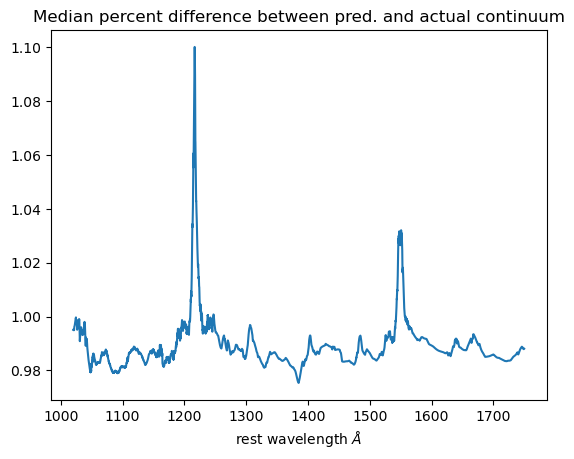

In [770]:
#X_pp is actual
spectral_flucs_full =  np.dot(pred_weights[:N].T,evecs_full[:N])
median_pd = np.median(np.abs(spectral_flucs_full- X_pp)/X_pp,axis=0)
plt.plot(wave_grid,median_pd)
plt.xlabel(r"rest wavelength $\AA$")
plt.title("Median percent difference between pred. and actual continuum")


### Limitations

This was meant to be an exercise so I did not go into much detail on how to further improve this. Here are a list of ideas to think about:
- The wavelength in which the spectra are decomposed could be improved. In Paris et al. 2011, the found that enlarging this range was helpful.
- Normalization. I wasn't careful in my normalization method. There is likely something more sophisticated.
- This project is highly dependent on the hand-picked continuum that is was trained on.
- I didn't look carefully at the spectral differences in the UV and VIS bands for XQ-100.
- These quasars cover a large redshift range. Things would likely be more consistent if we used a smaller redshift range.
- More principal components could be tested to see if things improve
- Lastly, there may be some normalization missing or an alternative method necessary in order to implement the projection matrices correctly.

### Conclusion

In this project, I used principal component analysis on 100 quasars from the XQ-100 dataset in order to predict the continuum blue-ward of the lyman-alpha line from the continuum redward of it.

Here are the main results:
- After normalization, the the quasars in the dataset have similar shape.
- From the correlation matrix, one can see that there moderate correlation between the redside and the continuum of the Lyman-alpha forest.
- Principle components are computed for the full and red-side spectra and then a projection matrix is calculated to enable the conversion of red-side weights to the full spectrum weights.
- Over 95% of the variance is accounted for when using 10 principal components (this is BEFORE applying the projection matrix). So this just shows that the shape of the quasar spectra (without trying to make any predictions outside of the wavelength range) can have a reduces dimensionality to 10 PCS and still expain most of the variance.
- I reconstruct the full continuum using red-side continuum and find that the median percent difference is mostly less than 5% except at some emission lines where is can reach up to 10%